In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import husl

In [46]:
def generate_sample_data(node_numbers, num_time_steps=24*4, seed=42):
    """
    生成示例多元时间序列数据。

    :param node_numbers: 节点编号列表
    :param num_time_steps: 时间步数量（例如4天，每天24步）
    :param seed: 随机种子
    :return: pandas DataFrame，行表示时间步，列表示不同节点
    """
    np.random.seed(seed)
    time = np.arange(num_time_steps)
    data = {}
    for node in node_numbers:
        # 生成不同的正弦波，添加随机噪声
        freq = np.random.uniform(0.1, 0.5)
        phase = np.random.uniform(0, 2 * np.pi)
        amplitude = np.random.uniform(5, 10)
        noise = np.random.normal(15 + (node%2)*5 + (node%3)*5, 5, num_time_steps)
        data[f'Node {node}'] = amplitude * np.sin(np.pi * freq * time + phase) + noise
    df = pd.DataFrame(data)
    return df

def split_nodes_into_pairs(nodes, num_pairs=4):
    """
    将节点列表分成指定数量的对。

    :param nodes: 节点名称列表
    :param num_pairs: 对的数量
    :return: 节点对列表
    """
    if len(nodes) < num_pairs * 2:
        raise ValueError("节点数量不足以分成指定数量的对。")
    # 固定分组顺序，可以根据实际需求调整
    pairs = []
    for i in range(num_pairs):
        pair = (nodes[2*i], nodes[2*i + 1])
        pairs.append(pair)
    return pairs

def compute_unpredictability(time_series, window=3, threshold=10.0):
    """
    计算并标记时间序列中的低可预测性区域。

    :param time_series: 一维numpy数组
    :param window: 计算滚动标准差的窗口大小
    :param threshold: 标记低可预测性的标准差阈值
    :return: boolean数组，True表示低可预测性区域
    """
    rolling_std = pd.Series(time_series).rolling(window=window, center=True).std().fillna(0).values
    unpredictability = rolling_std > threshold
    return unpredictability

def find_unpredictable_regions(unpredictability):
    """
    找出连续的低可预测性区域。

    :param unpredictability: boolean数组，True表示低可预测性区域
    :return: list of tuples，表示低可预测性区域的开始和结束索引
    """
    regions = []
    in_region = False
    start = 0
    for i, val in enumerate(unpredictability):
        if val and not in_region:
            in_region = True
            start = i
        elif not val and in_region:
            in_region = False
            regions.append((start, i))
    if in_region:
        regions.append((start, len(unpredictability)))
    return regions

In [47]:
def plot_time_series_pairs(df, pairs, node_type_mapping, output_path=None):
    """
    绘制时间序列对的子图，突出低可预测性区域。

    :param df: pandas DataFrame，时间序列数据
    :param pairs: 节点对列表
    :param node_type_mapping: 节点与类型的映射字典
    :param output_path: 输出图像路径（可选）
    """
    sns.set(style="whitegrid")  # 使用白色网格背景
    num_pairs = len(pairs)
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    axes = axes.flatten()
    
    # 定义基础色相和亮度差
    base_hue = 90  # 选择一个基础色相
    hue_difference = 45
    lightness_values = [70, 50]  # 两个亮度等级

    palette = []

    for i in range(num_pairs):
        hue = (base_hue + i * hue_difference) % 360
        for lightness in lightness_values:
            color = husl.husl_to_hex(hue, 80, lightness)
            palette.append(color)
 
    print(palette)

    # 使用轻色调的调色板
    #palette = sns.color_palette("Pastel1", 8)  # 每个节点2个颜色，共4对
    #print(palette)
    
    for idx, pair in enumerate(pairs):
        node1, node2 = pair
        ax = axes[idx]
        
        # 获取时序数据
        ts1 = df[node1].values
        ts2 = df[node2].values
        
        # 绘制时间序列
        ax.plot(ts1, label=f"{node1} ({node_type_mapping[node1]})", 
                color=palette[2*idx], linewidth=3)
        ax.plot(ts2, label=f"{node2} ({node_type_mapping[node2]})", 
                color=palette[2*idx +1], linewidth=3)
        
        # 计算并标记低可预测性区域
        unpredict1 = compute_unpredictability(ts1, window=3, threshold=10.0)
        unpredict2 = compute_unpredictability(ts2, window=3, threshold=10.0)
        unpredict = unpredict1 | unpredict2
        #ax.fill_between(np.arange(len(ts1)), 0, 70, where=unpredict, color='gray', alpha=0.2, label='Low Predictability')
        #regions = find_unpredictable_regions(unpredict)
        #for (start, end) in regions:
        #    ax.axvspan(start, end, color='lightgray', alpha=0.2)
        
        # 设置轴标签（全局）
        # 将子图的x轴和y轴标签隐藏，以便全局设置
        ax.set_xlim(0, 24)  # 假设每小时一个时间步
        ax.set_ylim(0, 70)
        ax.set_xlabel("")  # 隐藏子图的x轴标签
        ax.set_ylabel("")  # 隐藏子图的y轴标签
        
        # 添加图例
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.minorticks_on()  # 打开次要刻度线
        
    # 设置全局的x轴和y轴标签
    fig.text(0.5, 0.04, "Time Step", ha='center', fontsize=20)
    fig.text(0.04, 0.5, "Parking Availability", va='center', rotation='vertical', fontsize=20)
    
    # 设置整体标题
    fig.suptitle("4 Day Parking Availability Of Selected Parking Lots", fontsize=20, fontweight='bold')
    
    # 调整布局，确保标题和全局标签不被遮挡
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    
    if output_path:
        plt.savefig(output_path, dpi=300)
    plt.show()

节点对：
pair 1: Node 935 & Node 922
pair 2: Node 924 & Node 921
pair 3: Node 923 & Node 920
pair 4: Node 1672 & Node 929
['#abb14b', '#777b32', '#4cc16e', '#33874b', '#51bcb0', '#36837b', '#55b7db', '#397f99']


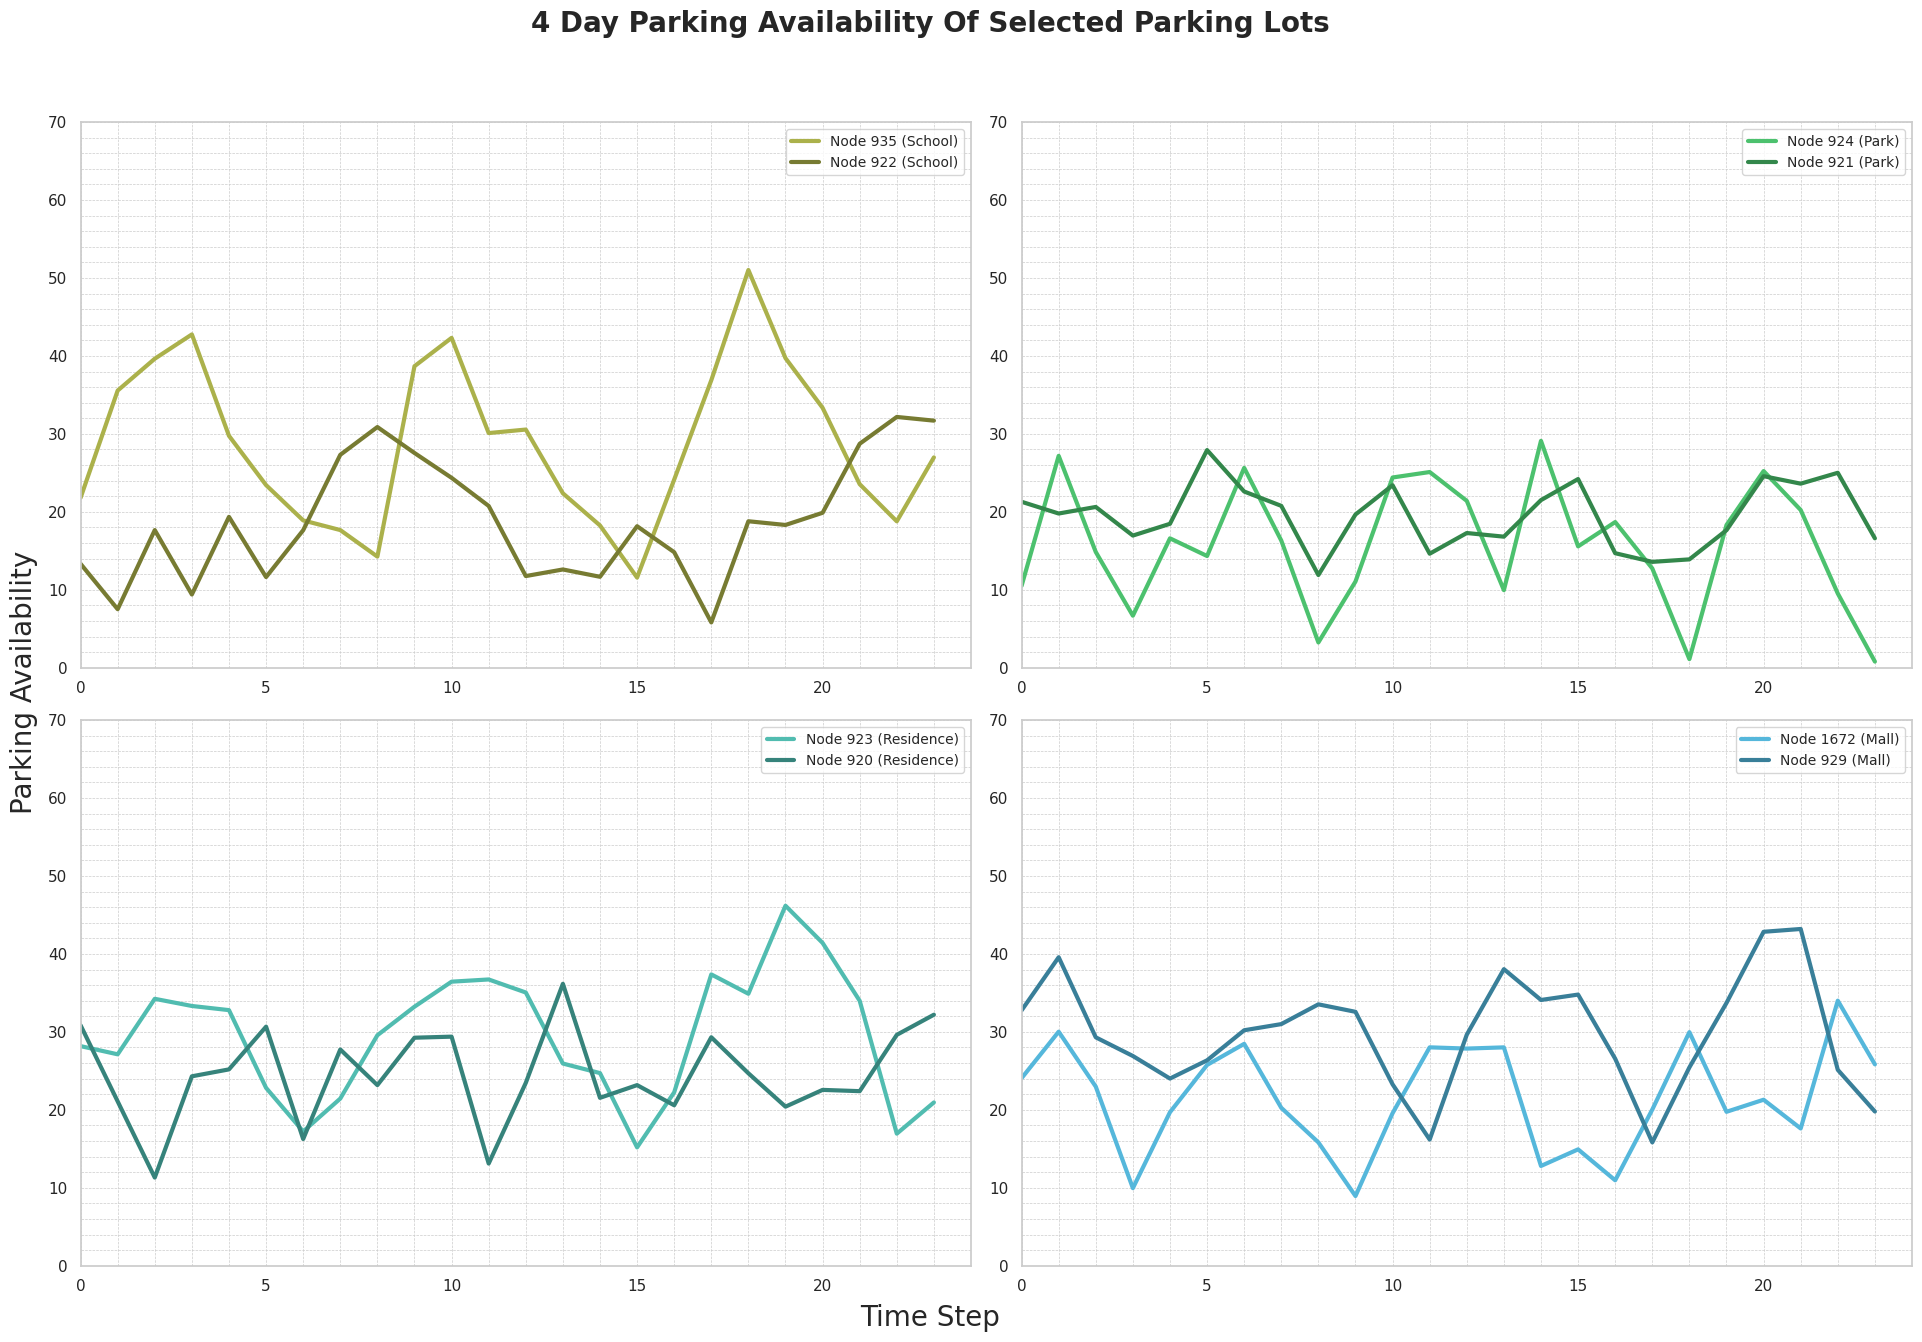

In [48]:
def main():
    # 1. 定义节点编号和类型
    node_numbers = [935, 922, 924, 921, 923, 920, 1672, 929]
    node_types = ["School", "School", "Park", "Park", "Residence", "Residence", "Mall", "Mall"]  # Type对应各节点编号
    node_type_mapping = {f'Node {node}': type_ for node, type_ in zip(node_numbers, node_types)}
    
    # 2. 生成多元时间序列数据，使用实际节点编号
    df = generate_sample_data(node_numbers, num_time_steps=24, seed=42)  # 4天，每天24步，共96步
    
    # 3. 定义节点对（固定顺序分组）
    nodes = [f'Node {node}' for node in node_numbers]
    pairs = split_nodes_into_pairs(nodes, num_pairs=4)
    
    print("节点对：")
    for i, pair in enumerate(pairs, 1):
        print(f"pair {i}: {pair[0]} & {pair[1]}")
    
    # 4. 绘制时间序列对
    plot_time_series_pairs(df, pairs, node_type_mapping, output_path='time_series_pairs.png')

if __name__ == "__main__":
    main()